In [45]:
import os
import nrrd
import pandas as pd
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import shutil

In [46]:
excel_file_path = "/kaggle/input/lung-tumor-ds/dataset_lung.xlsx" 
train_folder = "/kaggle/input/lung-tumor-ds/Train" 

output_dir = "/kaggle/working/lung-ds"
output_folder_full_slice = os.path.join(output_dir, "Full_slice")
output_folder_nodule = os.path.join(output_dir, "Nodule")

In [47]:
if os.path.exists(output_dir):
    shutil.rmtree(output_dir)  

In [48]:
df = pd.read_excel(excel_file_path)
df['TumorClass'] = df['TumorClass'] - 1

In [50]:
def balance_classes(df, label_column):
    class_counts = df[label_column].value_counts()
    print("Original class distribution:")
    print(class_counts)

    # Determine thresholds
    max_target = int(class_counts.mean())  # Downsample majority classes to mean size
    min_target = int(class_counts.mean())  # Upsample minority classes to mean size

    dfs = []

    for label in df[label_column].unique():
        label_data = df[df[label_column] == label]
        current_count = len(label_data)

        if current_count > max_target:
            # Downsample majority class
            downsampled_data = resample(
                label_data,
                replace=False,  # Sample without replacement
                n_samples=max_target,
                random_state=42
            )
            dfs.append(downsampled_data)

        elif current_count < min_target:
            # Upsample minority class
            upsampled_data = resample(
                label_data,
                replace=True,  # Sample with replacement
                n_samples=min_target,
                random_state=42
            )
            dfs.append(upsampled_data)

        else:
            # Keep as is
            dfs.append(label_data)

    # Combine balanced data
    df_balanced = pd.concat(dfs)

    # Shuffle the dataset
    df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

    # Verify new distribution
    print("\nBalanced class distribution:")
    print(df_balanced[label_column].value_counts())

    return df_balanced


In [51]:
from skimage import measure, morphology, segmentation
import scipy.ndimage as ndimage

def generate_markers(image):
    #Creation of the internal Marker
    marker_internal = image < -400
    marker_internal = segmentation.clear_border(marker_internal)
    marker_internal_labels = measure.label(marker_internal)
    areas = [r.area for r in measure.regionprops(marker_internal_labels)]
    areas.sort()
    if len(areas) > 2:
        for region in measure.regionprops(marker_internal_labels):
            if region.area < areas[-2]:
                for coordinates in region.coords:                
                       marker_internal_labels[coordinates[0], coordinates[1]] = 0
    marker_internal = marker_internal_labels > 0
    #Creation of the external Marker
    external_a = ndimage.binary_dilation(marker_internal, iterations=10)
    external_b = ndimage.binary_dilation(marker_internal, iterations=55)
    marker_external = external_b ^ external_a
    #Creation of the Watershed Marker matrix
    marker_watershed = np.zeros((512, 512), dtype=np.int64)
    marker_watershed += marker_internal * 255
    marker_watershed += marker_external * 128
    
    return marker_internal, marker_external, marker_watershed

def seperate_lungs(image):
    #Creation of the markers as shown above:
    marker_internal, marker_external, marker_watershed = generate_markers(image)
    
    #Creation of the Sobel-Gradient
    sobel_filtered_dx = ndimage.sobel(image, 1)
    sobel_filtered_dy = ndimage.sobel(image, 0)
    sobel_gradient = np.hypot(sobel_filtered_dx, sobel_filtered_dy)
    sobel_gradient *= 255.0 / np.max(sobel_gradient)
    
    #Watershed algorithm
    watershed = segmentation.watershed(sobel_gradient, marker_watershed)
    
    #Reducing the image created by the Watershed algorithm to its outline
    outline = ndimage.morphological_gradient(watershed, size=(3,3))
    outline = outline.astype(bool)
    
    #Performing Black-Tophat Morphology for reinclusion
    #Creation of the disk-kernel and increasing its size a bit
    blackhat_struct = [[0, 0, 1, 1, 1, 0, 0],
                       [0, 1, 1, 1, 1, 1, 0],
                       [1, 1, 1, 1, 1, 1, 1],
                       [1, 1, 1, 1, 1, 1, 1],
                       [1, 1, 1, 1, 1, 1, 1],
                       [0, 1, 1, 1, 1, 1, 0],
                       [0, 0, 1, 1, 1, 0, 0]]
    
    blackhat_struct = ndimage.iterate_structure(blackhat_struct, 8)
    #Perform the Black-Hat
    outline += ndimage.black_tophat(outline, structure=blackhat_struct)
    
    #Use the internal marker and the Outline that was just created to generate the lungfilter
    lungfilter = np.bitwise_or(marker_internal, outline)
    #Close holes in the lungfilter
    #fill_holes is not used here, since in some slices the heart would be reincluded by accident
    lungfilter = ndimage.morphology.binary_closing(lungfilter, structure=np.ones((7,7)), iterations=3)
    
    #Apply the lungfilter (note the filtered areas being assigned -2000 HU)
    segmented = np.where(lungfilter == 1, image, -2000*np.ones((512, 512)))

    #### nodule
    lung_nodule_1 = np.bitwise_or(marker_internal, image)
    lung_nodule = np.where(lungfilter == 1, lung_nodule_1, np.zeros((512, 512)))
    
    return segmented, outline


In [52]:
test_images = []

In [53]:
def get_unique_filename(save_path):
    base, ext = os.path.splitext(save_path)
    counter = 0
    unique_path = save_path

    while os.path.exists(unique_path):
        unique_path = f"{base}_{counter}{ext}"
        counter += 1

    return unique_path

def convert_nrrd_to_image(nrrd_path, save_path, resize_to=None):
    data, header = nrrd.read(nrrd_path)

    min_v = np.min(data)
    max_v = np.max(data)
    #hu_min, hu_max = -50, 100
    #test_segmented, test_outline = seperate_lungs(data)
    #data_filtered = np.where(test_outline == True, 0, test_segmented)
    
    #data_clipped = np.where((data >= hu_min) & (data <= hu_max), data, min_v)
    normalized = (data - min_v) / (max_v - min_v)


    # Convert to grayscale and then RGB
    grayscale_image = (normalized * 255).astype(np.uint8)
    rgb_image = np.stack([grayscale_image] * 3, axis=-1)

    test_images.append(rgb_image)

    # Create a PIL image
    pil_image = Image.fromarray(rgb_image)

    # Resize if needed
    if resize_to is not None:
        pil_image = pil_image.resize(resize_to)

    # Ensure the save path is unique
    unique_save_path = get_unique_filename(save_path)

    # Save the image
    pil_image.save(unique_save_path)

In [54]:
def create_imagefolder_dataset_with_split(df, image_column, label_column, output_folder, source_folder, train_ratio=0.8, resize_to=None):
    train_folder = os.path.join(output_folder, "train")
    val_folder = os.path.join(output_folder, "val")      
    
    os.makedirs(train_folder, exist_ok=True)
    os.makedirs(val_folder, exist_ok=True)

    # Group by label and split
    for label in df[label_column].unique():
        label_data = df[df[label_column] == label]

        train_data, val_data = train_test_split(label_data, test_size=1-train_ratio, random_state=42)

        # Create label subfolders
        train_label_folder = os.path.join(train_folder, str(label))
        val_label_folder = os.path.join(val_folder, str(label))
        os.makedirs(train_label_folder, exist_ok=True)
        os.makedirs(val_label_folder, exist_ok=True)

        print(train_data.shape)

        counterTrain = 0
        counterVal = 0

        # Save images to respective folders
        for _, row in train_data.iterrows():
            nrrd_name = row[image_column]
            source_path = os.path.join(source_folder, nrrd_name)
            dest_path = os.path.join(train_label_folder, nrrd_name.replace('.nrrd', '.png'))
            convert_nrrd_to_image(source_path, dest_path, resize_to=resize_to)
            counterTrain += 1
            print("PROCESSED TRAIN " + str(counterTrain))

        for _, row in val_data.iterrows():
            nrrd_name = row[image_column]
            source_path = os.path.join(source_folder, nrrd_name)
            dest_path = os.path.join(val_label_folder, nrrd_name.replace('.nrrd', '.png'))
            convert_nrrd_to_image(source_path, dest_path, resize_to=resize_to)
            counterVal += 1
            print("PROCESSED VAL " + str(counterVal))

        print(counterTrain)
        print(counterVal)

    print(f"Train/val split dataset created in {output_folder}")

In [55]:
df_balanced = balance_classes(df, label_column="TumorClass")

create_imagefolder_dataset_with_split(
    df=df_balanced,
    image_column="Full_slice",
    label_column="TumorClass",
    output_folder=output_folder_full_slice,
    source_folder=train_folder
)

create_imagefolder_dataset_with_split(
    df=df_balanced,
    image_column="Nodule",
    label_column="TumorClass",
    output_folder=output_folder_nodule,
    source_folder=train_folder,
    resize_to=(96, 96)
    
)

Original class distribution:
TumorClass
2    1092
1     457
3     418
0     244
4     152
Name: count, dtype: int64

Balanced class distribution:
TumorClass
1    472
0    472
2    472
4    472
3    472
Name: count, dtype: int64
(377, 3)
PROCESSED TRAIN 1
PROCESSED TRAIN 2
PROCESSED TRAIN 3
PROCESSED TRAIN 4
PROCESSED TRAIN 5
PROCESSED TRAIN 6
PROCESSED TRAIN 7
PROCESSED TRAIN 8
PROCESSED TRAIN 9
PROCESSED TRAIN 10
PROCESSED TRAIN 11
PROCESSED TRAIN 12
PROCESSED TRAIN 13
PROCESSED TRAIN 14
PROCESSED TRAIN 15
PROCESSED TRAIN 16
PROCESSED TRAIN 17
PROCESSED TRAIN 18
PROCESSED TRAIN 19
PROCESSED TRAIN 20
PROCESSED TRAIN 21
PROCESSED TRAIN 22
PROCESSED TRAIN 23
PROCESSED TRAIN 24
PROCESSED TRAIN 25
PROCESSED TRAIN 26
PROCESSED TRAIN 27
PROCESSED TRAIN 28
PROCESSED TRAIN 29
PROCESSED TRAIN 30
PROCESSED TRAIN 31
PROCESSED TRAIN 32
PROCESSED TRAIN 33
PROCESSED TRAIN 34
PROCESSED TRAIN 35
PROCESSED TRAIN 36
PROCESSED TRAIN 37
PROCESSED TRAIN 38
PROCESSED TRAIN 39
PROCESSED TRAIN 40
PROCESSED TR

<ipython-input-53-961ef34c6666>:22: RuntimeWarning: overflow encountered in scalar subtract
  normalized = (data - min_v) / (max_v - min_v)


PROCESSED VAL 24
PROCESSED VAL 25
PROCESSED VAL 26
PROCESSED VAL 27
PROCESSED VAL 28
PROCESSED VAL 29
PROCESSED VAL 30
PROCESSED VAL 31
PROCESSED VAL 32
PROCESSED VAL 33
PROCESSED VAL 34
PROCESSED VAL 35
PROCESSED VAL 36
PROCESSED VAL 37
PROCESSED VAL 38
PROCESSED VAL 39
PROCESSED VAL 40
PROCESSED VAL 41
PROCESSED VAL 42
PROCESSED VAL 43
PROCESSED VAL 44
PROCESSED VAL 45
PROCESSED VAL 46
PROCESSED VAL 47
PROCESSED VAL 48
PROCESSED VAL 49
PROCESSED VAL 50
PROCESSED VAL 51
PROCESSED VAL 52
PROCESSED VAL 53
PROCESSED VAL 54
PROCESSED VAL 55
PROCESSED VAL 56
PROCESSED VAL 57
PROCESSED VAL 58
PROCESSED VAL 59
PROCESSED VAL 60
PROCESSED VAL 61
PROCESSED VAL 62
PROCESSED VAL 63
PROCESSED VAL 64
PROCESSED VAL 65
PROCESSED VAL 66
PROCESSED VAL 67
PROCESSED VAL 68
PROCESSED VAL 69
PROCESSED VAL 70
PROCESSED VAL 71
PROCESSED VAL 72
PROCESSED VAL 73
PROCESSED VAL 74
PROCESSED VAL 75
PROCESSED VAL 76
PROCESSED VAL 77
PROCESSED VAL 78
PROCESSED VAL 79
PROCESSED VAL 80
PROCESSED VAL 81
PROCESSED VAL 

In [56]:
random_indices = np.random.choice(test_images.shape[0], 10, replace=False)

# Create a figure to plot 10 images
plt.figure(figsize=(15, 6))

for i, idx in enumerate(random_indices):
    # Select the subplot
    plt.subplot(2, 5, i + 1)
    plt.imshow(test_images[idx], cmap='gray' if test_images[idx].ndim == 2 else None)
    plt.axis('off')  # Turn off axes
    plt.title(f"Image {idx}")

plt.tight_layout()
plt.show()

AttributeError: 'list' object has no attribute 'shape'

In [57]:
def count_elements_in_folder(folder_path):
    try:
        # List all elements in the folder
        elements = os.listdir(folder_path)
        
        # Count the elements
        count = len(elements)
        print(f"The folder '{folder_path}' contains {count} elements.")
        return count
    except FileNotFoundError:
        print(f"The folder '{folder_path}' does not exist.")
        return 0
    except Exception as e:
        print(f"An error occurred: {e}")
        return 0

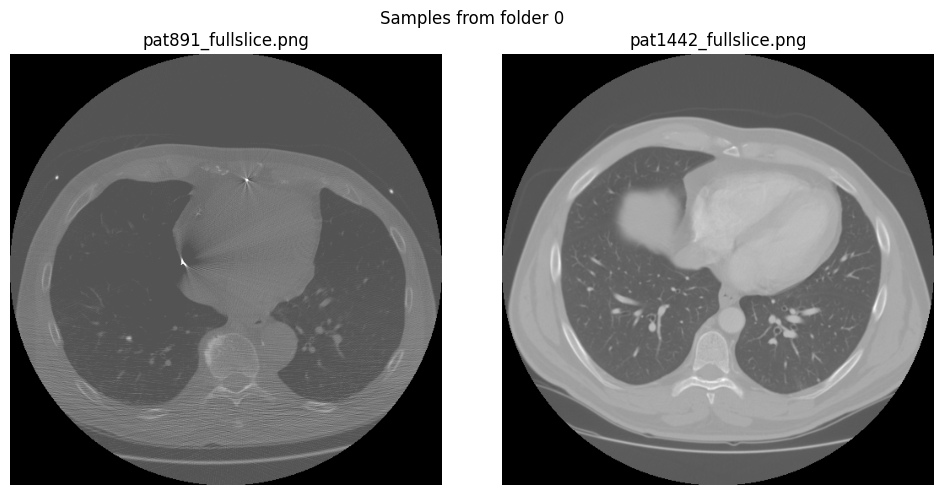

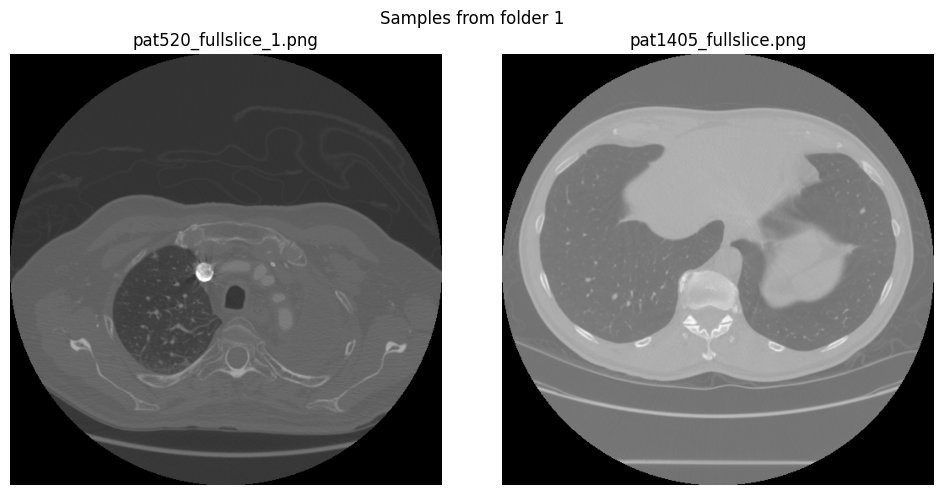

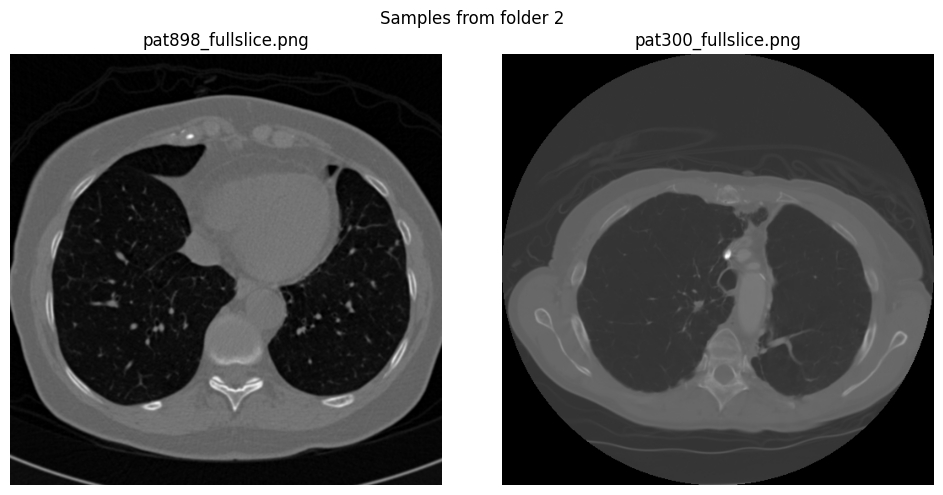

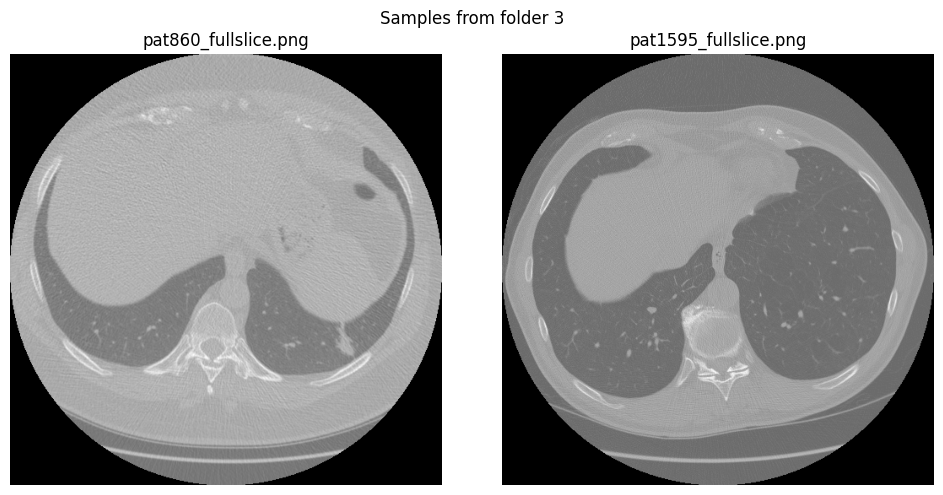

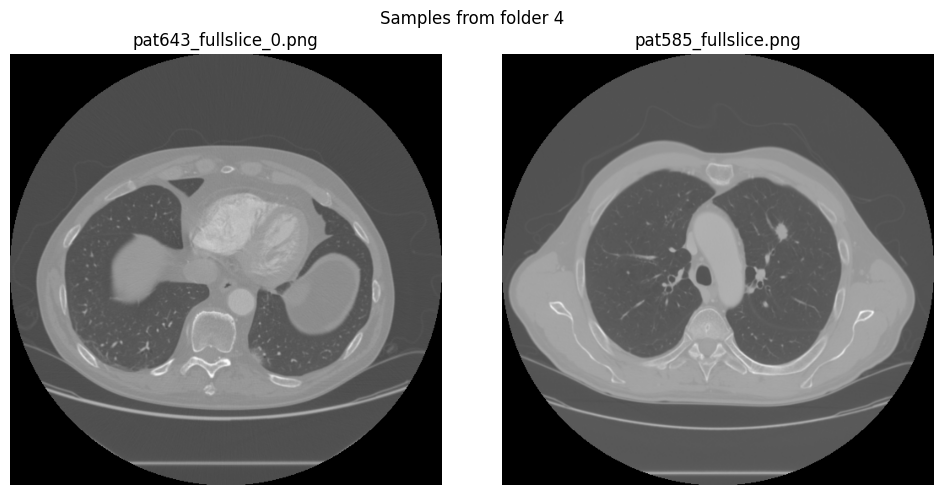

In [60]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

# Base path of the directories
base_path = '/kaggle/working/lung-ds/Full_slice/train/'

# Iterate through folders 0 to 4
for folder in range(5):
    folder_path = os.path.join(base_path, str(folder))
    
    if not os.path.exists(folder_path):
        print(f"Folder {folder_path} does not exist.")
        continue

    # Get all files in the folder
    files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

    if len(files) < 2:
        print(f"Folder {folder_path} has less than 2 files.")
        continue

    # Randomly select 2 files
    sample_files = random.sample(files, 2)

    # Plot the samples
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    fig.suptitle(f"Samples from folder {folder}")

    for ax, file in zip(axes, sample_files):
        file_path = os.path.join(folder_path, file)
        img = mpimg.imread(file_path)
        ax.imshow(img, cmap='gray')  # Assuming the images are grayscale
        ax.set_title(file)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

In [59]:
import shutil
shutil.make_archive("lung-ds", 'zip', output_dir)

'/kaggle/working/lung-ds.zip'